# Deep Learning para Extracción de características

Este laboratorio ha sido extendido de la versiòn de (https://github.com/chsasank/image_features)

Busca características de imagen genéricas para

*   Clasificación de imágenes
*   Recuperación de imágenes
*   Similitud de imagen

Con image_features, se pueden extraer características  de las imágenes basadas en el aprendizaje profundo con una sola línea de código:
```
from image_features import image_features
features = image_features(['your_image_1.png', 'your_image_2.jpg'])
```
Estas caracteríticas podrán ser usadas para entrenar un modelo de clasificación de scikit-learn:
```
from sklearn import linear_model
from image_features import image_features
X_train = image_features(['your_image_1.png', 'your_image_2.jpg'])
y_train = ['cat', 'dog']
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
```

El paquete utiliza internamente PyTorch y el modelo de aprendizaje profundo resnet50 preentrenado en imagenet. Dado que el modelo preentrenado ha visto más de un millón de imágenes durante su entrenamiento, sus características pueden generalizarse a la mayoría de las tareas de imágenes. 

En primera instancia cargaremos la libreria de Image Featrues (`image_features`)

In [ ]:
!pip install -U git+https://github.com/chsasank/image_features.git

  Cloning https://github.com/chsasank/image_features.git to /tmp/pip-req-build-thdsroru
  Running command git clone -q https://github.com/chsasank/image_features.git /tmp/pip-req-build-thdsroru
  Created wheel for image-features: filename=image_features-0.1-cp36-none-any.whl size=4175 sha256=5bf9db459e53271bc52daac12f66c3cb23ebad72c89a6cf5add9d896f79cd513
  Stored in directory: /tmp/pip-ephem-wheel-cache-4odfmz94/wheels/b8/58/5c/d16f6f3a2fc54b1074b2e5f2cb6dc9d7454f8a2f4acbf82a33
Successfully built image-features
  Found existing installation: image-features 0.1
    Uninstalling image-features-0.1:
      Successfully uninstalled image-features-0.1


Para este experimentp se creó un Dataset con imagenes de prendas de vestir. El estilo de vestir cubierto (Layered) será identificado como la clase negativa, mientras que un estilo sin abrigos ni prendas adicionales se identificará como la clase positiva.

In [ ]:
#Load the data files
!wget https://storage.googleapis.com/public-sasank/sartorialist_images.zip

--2020-10-24 15:40:08--  https://storage.googleapis.com/public-sasank/sartorialist_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73018658 (70M) [application/zip]
Saving to: ‘sartorialist_images.zip.1’

sartorialist_images 100%[===================>]  69.64M  94.9MB/s    in 0.7s    

2020-10-24 15:40:09 (94.9 MB/s) - ‘sartorialist_images.zip.1’ saved [73018658/73018658]



Se descomprime el conjunto de imagenes descargado.

In [ ]:
!unzip sartorialist_images.zip

Archive:  sartorialist_images.zip
replace archive/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: archive/.DS_Store       
replace __MACOSX/archive/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/archive/._.DS_Store  
  inflating: archive/images/photos_s1600_almostperfect.jpg  
  inflating: archive/images/thumbnails_2014_11_11314_bookscan7.jpg  
  inflating: archive/images/photos_1600_Boltsred3.jpg  
  inflating: archive/images/photos_1600_Charvet%20Collars3.1.jpg  
  inflating: archive/images/photos_5311FIT27_0090Web.jpg  
  inflating: archive/images/thumbnails_2013_09_91813phone8729web1.jpg  
  inflating: archive/images/thumbnails_2017_02_2817jj1124.jpg  
  inflating: archive/images/thumbnails_2014_04_11714Whtjeans0032Web.jpg  
  inflating: archive/images/thumbnails_2012_12_90912Illus9054AWeb.jpg  
  inflating: archive/images/photos_s1600_SilverEyesFullweb.jpg  
  inflating: archive/images/photos_1600_TBNippon.jpg  
  inflating: archive/imag

Identificamos el listado de anotaciones realizado para el dataset de Imagenes, se creará una lista con el contenido de la ruta de cada una de las imágenes y otra con la etiqueta Verdadero/Falso (True/False), según sea el caso.

In [ ]:
import pandas as pd
df = pd.read_csv('archive/annotations.csv')
img_paths = list(df['path'])
no_layer = list(df['no_layer'])
#Describimos los primeros 5 ejemplos, con sus etiequetas.
print(df.head(5))

FileNotFoundError: ignored

Graficamos algunos ejemplos mediant una matriz , puede seleccionar el numero de columnas y filas que desee representar en (`rows` y `columns`) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


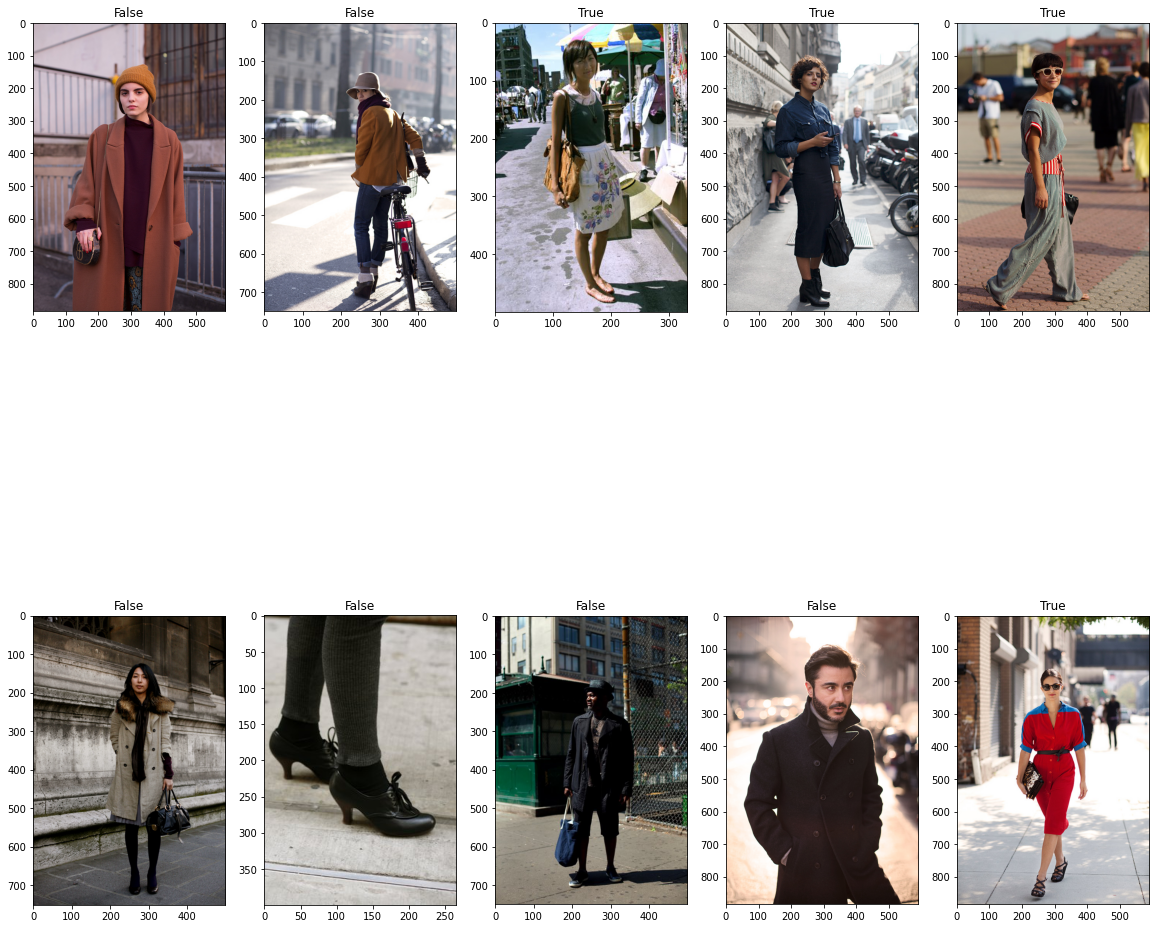

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

rows=3
columns=3

plt.figure(figsize=(20,20))

cont=0

for i in range(rows):
    for j in range(columns):
        plt.subplot(rows,columns,cont+1)
        plt.subplot(rows,columns,cont+1).set_title(no_layer[cont])
        plt.imshow(mpimg.imread(img_paths[cont]))
        cont=cont+1
    print('\n')


Seleccionamos el 80% de imagenes para entrenamiento y el restante para evaluación. 
<br>Y utilizasmo la librería de extracción de caracteríticas `image_features` para extraer los vectores de características por cada imagen. 
<br>El Proceso uede tomar algún tiempo, pues cada imagen será procesada por ResNet50, que ha sido previamente entrenada en el dataset de Imagenet, para así extraer las características.

In [ ]:
from image_features import image_features

n = round(0.8 * len(img_paths))
X_train = image_features(img_paths[:n], progress=True)
y_train = no_layer[:n]

X_val = image_features(img_paths[n:], progress=True)
y_val = no_layer[n:]

Computing image features: 100%|██████████| 91/91 [00:19<00:00,  4.65it/s]


Una vez extraidas las caracteríticas, utilizaremos una regresión logística lineal con validación cruzada. Definimos que nuestras clases estan balanceadas en ejemplos, para evitar el sesgo del clasificador. Así mismo establecemos un maximo de iteraciones para el aprendizaje de 1000 iteraciones.

In [ ]:
from sklearn import linear_model
import numpy as np
clf = linear_model.LogisticRegressionCV(
    max_iter=1000,
    Cs=np.geomspace(1e-1, 1e-7, 15),
    class_weight='balanced'
)
clf.fit(X_train, y_train)
print('train score:', clf.score(X_train, y_train))
print('val score:', clf.score(X_val, y_val))

train score: 0.931129476584022
val score: 0.945054945054945
Train Set Real Class:  [False, False, True, True, True]
Predicted in Train Set Class:  [False False  True False  True]
Evaluation Set Real Class:  [True, False, True, True, True]
Predicted in Evaluation Set Class:  [ True False False  True  True]


El modelo alcanza una precisión del 94% en el conjunto de evaluación. La matriz de confusión nos muestra que se presentan mayores imprecisiones en la clase Negativa.

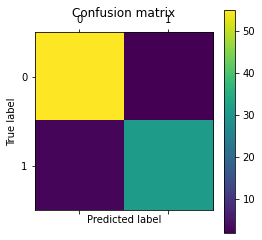

In [ ]:
import matplotlib
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix

preds=clf.predict(X_val)

cm = confusion_matrix(y_val, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Podemos observar que en los primeros cinco ejemplos se presentan algunas imrecisiones en la detección:

In [ ]:
print('Train Set Real Class: ',y_train[0:5])

print('Predicted in Train Set Class: ',clf.predict(X_train[0:5]))

print('Evaluation Set Real Class: ',y_val[0:5])

print('Predicted in Evaluation Set Class: ',clf.predict(X_val[0:5]))

Train Set Real Class:  [False, False, True, True, True]
Predicted in Train Set Class:  [False False  True False  True]
Evaluation Set Real Class:  [True, False, True, True, True]
Predicted in Evaluation Set Class:  [ True False False  True  True]


Ahora, vamos a cargar nuestra propia imagen. Busque en Internet una Imagen de una persona que luzca varias prendas (layered fashion). Bájela de manera local a su disco y carguela a este laboratorio (No olvide tener presente el nombre del archivo).


In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

En este caso se descargó una imagen que identificamos como `layered.jpg`. Modifique la ruta de asignación de acuerdo al nombre de la imagen que cargó en este laboratorio. 

 archive	   'nonLayered (1).jpg'   sartorialist_images.zip
'layered (1).jpg'  'nonLayered (2).jpg'   sartorialist_images.zip.1
 layered.jpg	    nonLayered.jpg
 __MACOSX	    sample_data


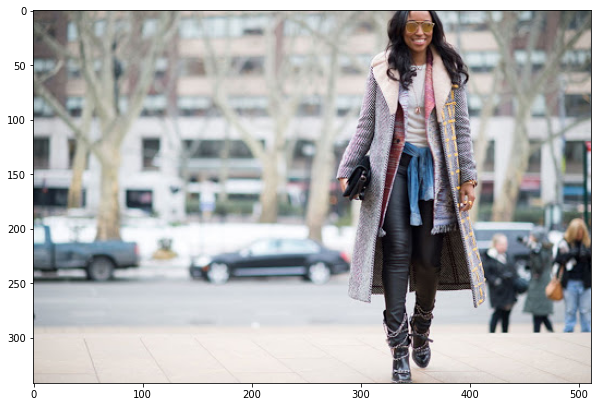

In [ ]:
import os
!ls
os.getcwd()

imagen1='/content/layered.jpg'


plt.figure(figsize=(10,10))

plt.imshow(mpimg.imread(imagen1))

Creamos un arreglo con la ruta de la imagen cargada al laboratorio y extraemos sus características.

In [ ]:
Pathimagen1=['/content/layered.jpg']
Imagen1Features = image_features(Pathimagen1, progress=True)

Computing image features: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


La Función crea un arreglo con sólo 2048 características que serán utilizadas para clasificar la imagen.

In [ ]:
print(Imagen1Features.shape)
print('Predicted in Train Set Class: ',clf.predict(Imagen1Features))

(1, 2048)
Predicted in Train Set Class:  [False]


Podemos intentar clasificar otra imagen que corresponda a la otra categoría. Buscando en internet (summer outfit). 

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving non.jpg to non.jpg
User uploaded file "non.jpg" with length 89477 bytes


Nos aseguramos que el nombre del archivo `imagen2` concuerde con el que hemos cargado al laboratorio.

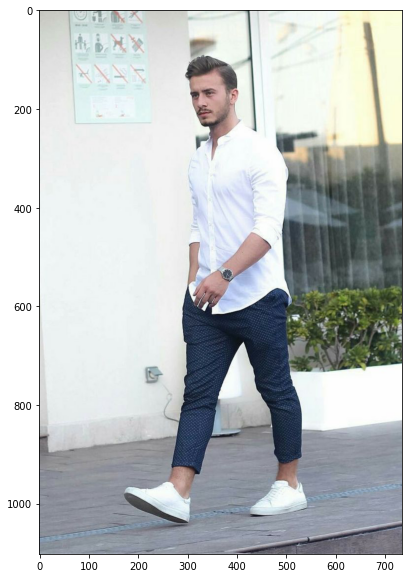

In [ ]:
imagen2='/content/non.jpg'


plt.figure(figsize=(10,10))

plt.imshow(mpimg.imread(imagen2))

Nuevamente, la Función creará un arreglo con las 2048 características que serán utilizadas para clasificar la imagen.

In [ ]:
Pathimagen2=['/content/non.jpg']
Imagen2Features = image_features(Pathimagen2, progress=True)
print(Imagen2Features.shape)
print('Predicted in Train Set Class: ',clf.predict(Imagen2Features))

Computing image features: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

(1, 2048)
Predicted in Train Set Class:  [ True]


Este proceso se puede utilizar con cualquier dataset, incluyendo uno con múltiples clases. Y se puede igualmente experimentar con varios tipos de clasificadores (SVMs, NNs, Deep Learning models)